# Quick Start for Network Wrangler

This notebook should give you a high-level overview of using Wrangler to do the following:  

1. Import a network to wrangler
2. Selections
3. Changes to attributes 
4. Write out networks  
5. Project cards to define selections, changes, and metadata
6. Scenarios to manage groups of projects

In [31]:
import os
import warnings
import sys

import numpy as np
import pandas as pd
import geopandas as gpd

from network_wrangler import RoadwayNetwork
from network_wrangler import ProjectCard
from network_wrangler import TransitNetwork

import osmnx as ox

import folium

from ipywidgets import HBox, VBox, Output
from IPython.display import display, HTML

%config IPCompleter.greedy=True
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger("WranglerLogger")
#logger.handlers[0].stream = sys.stdout
# if you don't want to see so much detail, set to logging.INFO or DEBUG
logger.setLevel(logging.INFO)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#if you need to reset variables in the notebook
%reset

# 1. Importing and viewing a network
## Locate network folder and files 

In [2]:
STPAUL_DIR = os.path.join(os.getcwd(),'../','examples','stpaul')

# Roadway Network files
STPAUL_SHAPE_FILE = os.path.join(STPAUL_DIR,"shape.geojson")
STPAUL_LINK_FILE = os.path.join(STPAUL_DIR,"link.json")
STPAUL_NODE_FILE = os.path.join(STPAUL_DIR,"node.geojson")

## Roadway Network
The roadway network is comprised of three components:
1. Nodes 
   - Keyed on whatever is specified in `RoadwayNetwork.UNIQUE_NODE_KEY`. Default is: `model_node_id`
2. Shapes
   - keyed on `shape_id`
3. Links
   - Keyed on whatever is specified in `RoadwayNetwork.UNIQUE_LINK_KEY`. Default is: `model_link_id`
   - Foreign key to nodes is based on `RoadwayNetwork.LINK_FOREIGN_KEY`. Default is: `["A", "B"]`
   - Foreign key to shapes is `shape_id` 

### Network Read
 - Read in the network specifying where each network component can be found
 

In [3]:
net = RoadwayNetwork.read(
    link_file= STPAUL_LINK_FILE, 
    node_file=STPAUL_NODE_FILE, 
    shape_file=STPAUL_SHAPE_FILE, 
    shape_foreign_key ='shape_id',
    fast=True        # fast=True means that the network isn't validated against its schema when it is read in. You will want to try both ways.
)

2020-11-13 16:20:47, INFO: Reading RoadwayNetwork
2020-11-13 16:20:54, INFO: Read 66253 links from /Users/elizabeth/Documents/urbanlabs/MetCouncil/working/network_wrangler/notebook/../examples/stpaul/link.json
2020-11-13 16:20:54, INFO: Read 17159 nodes from /Users/elizabeth/Documents/urbanlabs/MetCouncil/working/network_wrangler/notebook/../examples/stpaul/node.geojson
2020-11-13 16:20:54, INFO: Read 66253 shapes from /Users/elizabeth/Documents/urbanlabs/MetCouncil/working/network_wrangler/notebook/../examples/stpaul/shape.geojson


### Explore the roadway network

* look at first three rows of each network component

In [4]:
net.links_df[:3]

,model_link_id,osm_link_id,shstReferenceId,shstGeometryId,shape_id,u,v,A,B,locationReferences,distance,roadway,name,ref,bridge,tunnel,width,max_speed,bike_facility,drive_access,walk_access,bike_access,truck_access,bus_only,rail_only,lanes,access,price,trn_priority,ttime_assert,geometry
0,224,"18214905,18220565",6a22969708104ae2497244f3d079381d,4a454269d65c6619a2d7e2026295a295,9ef30f714e972087771ed705654fd1f5,493882040,187879468,3230,52771,"[{'sequence': 1, 'point': [-93.0837695, 44.963...",0.050322,residential,"Arkwright Street,North Rivoli Street",,,,,,3,False,True,True,False,False,False,1,,0,0,0.0,"LINESTRING (-93.08377 44.96334, -93.08324 44.9..."
1,280,18218485,bff76735795c148707c774d7f7a0fa6b,13e68dc0fe4477f10b9655ebbd5f8435,2ac3bd68a0d0a2d5e6c4f7dcfc19a36e,493882338,493882339,3261,3262,"[{'sequence': 1, 'point': [-93.0855338, 44.966...",0.070096,tertiary,East Cayuga Street,,,,,,0,True,False,False,True,False,False,2,,0,0,0.0,"LINESTRING (-93.08553 44.96621, -93.08431 44.9..."
2,281,"221685888,221685889,221685893",42b68a489b91dd5a1415fb25fb53de65,9ba14c0a7330177aa938ad0ec43b45f1,f6b3bee60aac5786dc35c6d51f7dab43,493882338,2307229054,3261,131209,"[{'sequence': 1, 'point': [-93.0855338, 44.966...",0.084513,tertiary,East Cayuga Street,,yes,,,,0,True,False,False,True,False,False,2,,0,0,0.0,"LINESTRING (-93.08553 44.96621, -93.08712 44.9..."


In [5]:
net.nodes_df[:3]

,model_node_id,osm_node_id,shstReferenceId,drive_node,walk_node,bike_node,bus_only,rail_only,outboundReferenceIds,inboundReferenceIds,geometry,X,Y
model_node_id_idx,,,,,,,,,,,,,
1924,1924,1924,,1,1,1,0,0,[],[],POINT (-93.13665 44.96983),-93.136654,44.969831
1925,1925,1925,,1,1,1,0,0,[],[],POINT (-93.13713 44.96468),-93.137132,44.964678
1930,1930,1930,,1,1,1,0,0,[],[],POINT (-93.14154 44.95373),-93.141544,44.953727


In [6]:
net.shapes_df[:3]

,id,shape_id,fromIntersectionId,toIntersectionId,forwardReferenceId,geometry
0,4a454269d65c6619a2d7e2026295a295,9ef30f714e972087771ed705654fd1f5,4d0231aa0ebb779f142c2518703ee481,3654951b676940911fe5021b93c90cc5,6a22969708104ae2497244f3d079381d,"LINESTRING (-93.08377 44.96334, -93.08376 44.9..."
1,13e68dc0fe4477f10b9655ebbd5f8435,2ac3bd68a0d0a2d5e6c4f7dcfc19a36e,b6ee5e5a4adca2f379b20fe7ee7ca77d,51013ccb2e52ee1ea83de6d36e4ef268,bff76735795c148707c774d7f7a0fa6b,"LINESTRING (-93.08553 44.96621, -93.08524 44.9..."
2,9ba14c0a7330177aa938ad0ec43b45f1,f6b3bee60aac5786dc35c6d51f7dab43,b6ee5e5a4adca2f379b20fe7ee7ca77d,863278524c056439c207888e8f09d04e,42b68a489b91dd5a1415fb25fb53de65,"LINESTRING (-93.08553 44.96621, -93.08574 44.9..."


## Transit Network

Transit network components represent a dataframe for each file.  Critical components include:

 - `routes` keyed on `route_id` with foreign keys `agency_id`
 - `stops` keyed on `stop_id`
 - `trips` keyed on `trip_id` with foreign keys `route_id`, `service_id`, `shape_id`
 - `stop_times` with foreign keys `trip_id` and `stop_id`
 - `frequencies` with foreign key `trip_id`

### Read Network

Specify the path where to find the transit network files

In [7]:
transit_net = TransitNetwork.read(feed_path=STPAUL_DIR)

2020-11-13 16:21:18, INFO: Read in transit feed from: /Users/elizabeth/Documents/urbanlabs/MetCouncil/working/network_wrangler/notebook/../examples/stpaul
2020-11-13 16:21:18, INFO: Removing calendar.txt from transit network config because file not found
2020-11-13 16:21:18, INFO: Removing calendar_dates.txt from transit network config because file not found
2020-11-13 16:21:18, INFO: Removing fare_attributes.txt from transit network config because file not found
2020-11-13 16:21:18, INFO: Removing fare_rules.txt from transit network config because file not found
2020-11-13 16:21:18, INFO: Removing transfers.txt from transit network config because file not found
2020-11-13 16:21:18, INFO: Removing feed_info.txt from transit network config because file not found


### Explore the transit network

* look at the first few components of each transit network component

In [8]:
transit_net.feed.routes[:3]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
0,3-111,0,3,U of M - Como Av - Energy Park Dr - Maryland Av,NaN,3,http://www.metrotransit.org/route/3,NaN,000000
1,16-111,2,16,University Av - Midway,NaN,3,http://www.metrotransit.org/route/16,NaN,000000
2,21-111,0,21,Uptown - Lake St - Midway - Selby Av,NaN,3,http://www.metrotransit.org/route/21,NaN,000000


In [9]:
transit_net.feed.stops[:3]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,wheelchair_boarding,model_node_id,osm_node_id,node_ssid,parent_station
0,10037,NaN,Fillmore Ave E & Robert St,Far side E,44.941361,-93.084769,NaN,http://www.metrotransit.org/NexTripBadge.aspx?...,0,1.0,57992,187891416,98e48a4ff360a8833c1f04b975fb8f73,NaN
1,10039,NaN,Fillmore Ave E & State St,Near side E,44.943261,-93.080287,NaN,http://www.metrotransit.org/NexTripBadge.aspx?...,0,2.0,46975,187868185,1203d85e0764f1e36a8a598977364db0,NaN
2,10040,NaN,Fillmore Ave E & Lafayette Rd W,Near side E,44.943613,-93.078382,NaN,http://www.metrotransit.org/NexTripBadge.aspx?...,0,2.0,57958,187891352,3127e296d73928bc1cec808a7acd6d3a,NaN


In [10]:
transit_net.feed.trips[0:3]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,trip_destination,trip_short_name,trip_route_name,pub_dir_id,rm_block_id
0,452-111,JUN19-MVS-BUS-Weekday-01,14940701-JUN19-MVS-BUS-Weekday-01,Westbound 452 Express / Minneapolis,1,1874,4520004,1.0,NaN,NaN,NaN,NaN,NaN
1,3-111,JUN19-MVS-BUS-Weekday-01,14941148-JUN19-MVS-BUS-Weekday-01,Eastbound 3B Como Av/St Paul - Depot/Via Front,0,1018,30009,1.0,NaN,NaN,NaN,NaN,NaN
2,3-111,JUN19-MVS-BUS-Weekday-01,14941151-JUN19-MVS-BUS-Weekday-01,Westbound 3B Como-Front/Dwtn Mpls/Target Field,1,1017,30014,1.0,NaN,NaN,NaN,NaN,NaN


In [11]:
transit_net.feed.stop_times[:3]

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_distance,timepoint,stop_is_skipped
0,14941148-JUN19-MVS-BUS-Weekday-01,0.0,0.0,18618,46,0,0,NaN,NaN,NaN
1,14941148-JUN19-MVS-BUS-Weekday-01,60.0,60.0,18619,47,0,0,NaN,NaN,NaN
2,14941148-JUN19-MVS-BUS-Weekday-01,60.0,60.0,18621,48,0,0,NaN,NaN,NaN


In [12]:
transit_net.feed.frequencies[0:3]

,trip_id,headway_secs,start_time,end_time
0,14940701-JUN19-MVS-BUS-Weekday-01,3600,21600.0,32400.0
1,14941148-JUN19-MVS-BUS-Weekday-01,830,21600.0,32400.0
2,14941151-JUN19-MVS-BUS-Weekday-01,540,21600.0,32400.0


In [13]:
transit_net.feed.shapes[:5]

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_osm_node_id,shape_model_node_id
0,4520004,44.923257,-93.067060,55,507955865,152495
1,4520004,44.930632,-93.071166,56,507951624,151635
2,4520004,44.932669,-93.071710,57,507951633,151637
3,4520004,44.939445,-93.075273,58,507951645,151641
4,4520004,44.943056,-93.076998,59,2548150957,23834


### Map Transit Network

Two network components hold geographic information for a transit network: `stops` and `shapes`.  Either of these can be converted into a GeoDataFrame to easily plot, and other information can be joined to them using foreign keys.

**Stops** can be converted to a geodataframe by converting the xy point to a geometry field.

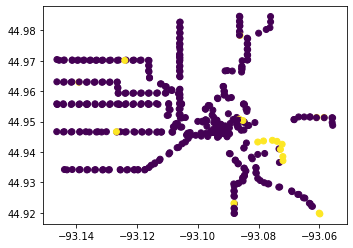

In [14]:
stops_gdf = gpd.GeoDataFrame(
    transit_net.feed.stops, geometry=gpd.points_from_xy(transit_net.feed.stops.stop_lon, transit_net.feed.stops.stop_lat))
stops_gdf.plot(column='wheelchair_boarding')

**Service** data can be viewed at a **stop** level by:

- selecting `trip_id`s for a particular `service_id`
- select `frequencies` for the time of day you want to look at
- merging `frequencies` to that `trip_id`
- merging that information to `stop_times` and then to `stop_ids`



2020-11-13 16:21:37, INFO: Selected 55 of 62 total trips with the service id: JUN19-MVS-BUS-Weekday-01
2020-11-13 16:21:37, INFO: Kept 36 trips with frequencies for the selected time: 8:00:00


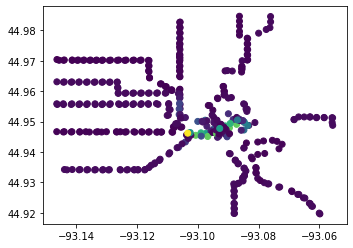

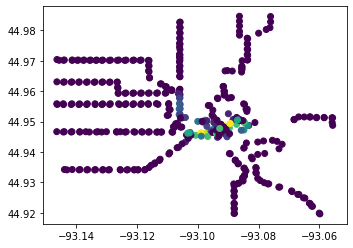

In [15]:
selected_service_id = transit_net.feed.trips.loc[0,'service_id'] #just pick the first one for now
time_of_day = "8:00:00" #24 hour time


# 1. Select trips for a service id
selected_trips = transit_net.feed.trips.loc[transit_net.feed.trips.service_id==selected_service_id][['trip_id','route_id','shape_id']]
logger.info("Selected {} of {} total trips with the service id: {}".format(
    len(selected_trips),
    len(transit_net.feed.trips), 
    selected_service_id)
)

# 2. Select frequencies for the time of day 
h,m,s = time_of_day.split(':')
time_of_day_sec = int(h) * 3600 + int(m) * 60 + int(s)
selected_frequencies = transit_net.feed.frequencies.loc[
    (transit_net.feed.frequencies.start_time<=time_of_day_sec) & 
    (transit_net.feed.frequencies.end_time>time_of_day_sec)
][['trip_id','headway_secs']]

selected_frequencies['buses_per_hour']= selected_frequencies['headway_secs']/3600 

# 3. Merge selected frequencies to selected trips

selected_trips=selected_trips.merge(selected_frequencies, how='inner', on='trip_id') 
# Do an inner join so if frequency NaN for that time period, it is deleted. 
# Alternativly could provide a different value to show "no service"

logger.info("Kept {} trips with frequencies for the selected time: {}".format(
    len(selected_trips),
    time_of_day)
)

# 4. Merge to stop_times 
stop_times = transit_net.feed.stop_times.merge(selected_trips, how='right', on='trip_id')    

# 5. Aggregate to stops

stop_level_service =  stop_times.groupby('stop_id').agg(
    buses_per_hour = ('buses_per_hour',sum),
    num_routes= ('route_id','nunique'),
    routes = ('route_id',list),
)             

stops_with_service = transit_net.feed.stops.merge(stop_level_service,how='left',on='stop_id')

stops_service_gdf = gpd.GeoDataFrame(
    stops_with_service, geometry=gpd.points_from_xy(stops_with_service.stop_lon, stops_with_service.stop_lat))
stops_service_gdf.plot(column='buses_per_hour')
stops_service_gdf.plot(column='num_routes')

**View the basic shapes**

By converting the shape to a GeoDataFrame

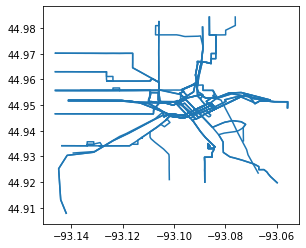

In [16]:
shapes_gdf = TransitNetwork.transit_net_to_gdf(transit_net)

shapes_gdf.plot()

**View service on shapes**

Similar to how it was viewed on stops, but merging and aggregating to shapes. 

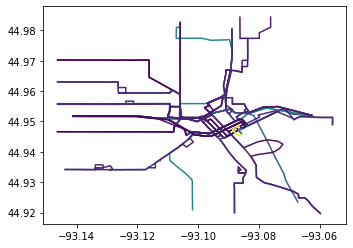

In [17]:
# Aggregate to shape_ids

service_by_shape_id =  selected_trips.groupby('shape_id').agg(
    buses_per_hour = ('buses_per_hour',sum),
    num_routes= ('route_id','nunique'),
    routes = ('route_id',list),
)  

# Merge to shapes
shapes_service_gdf = shapes_gdf.merge(service_by_shape_id, how='right',on='shape_id')


shapes_service_gdf.plot(column='buses_per_hour')

**View a routes or a single route**

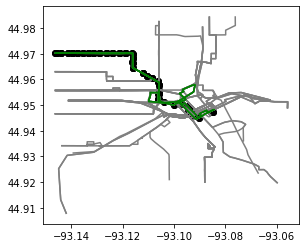

In [18]:
selected_route_id = '3-111'

shapes_gdf = TransitNetwork.transit_net_to_gdf(transit_net)
shapes_route_gdf = shapes_gdf.merge(
    transit_net.feed.trips[['trip_id','route_id','shape_id']], 
    how='right',
    on='shape_id'
)

sel_trips=transit_net.feed.trips[transit_net.feed.trips.route_id==selected_route_id]['trip_id'].to_frame()
sel_stops=transit_net.feed.stops.merge(
    transit_net.feed.stop_times.merge(sel_trips,how='right',on='trip_id'),
    how='right',
    on='stop_id',
)

sel_stops_gdf = gpd.GeoDataFrame(
    sel_stops, geometry=gpd.points_from_xy(sel_stops.stop_lon, sel_stops.stop_lat))

all_routes_ax = shapes_route_gdf.plot(color='grey')

shapes_route_gdf[shapes_route_gdf.route_id==selected_route_id].plot(ax=all_routes_ax, color='green')
sel_stops_gdf.plot(ax=all_routes_ax, color='black')


## 2. Query Network Features

Most of Network wrangler operates by querying a portion of the network and then making changes to it.  

Queries take the form of Python Dictionaries or can be read-in as YAML which is then converted to a python dictionary.

If a query has already been made, it is stored in the network so that it will not take up computing power to find it again.

### Highway Segment Selection

Highway selections have three required components: 'link', 'A', and 'B'.  

'link' must either have a specified name, or an 'osmid'

'A' and 'B' must specify some sort of unique identifier which is found in the data structure (AKA, it should return a single node).

If not all the links connecting A to B have the 'name' or an 'osmid', wrangler will connect the dots from A-->B using as many streets with the correct name/osmid as possible.

In [19]:
easy_highway_selection = \
{
    'link':[
        {'name': ['6th', 'Sixth', 'sixth']}, #find streets that have one of the various forms of 6th
        ],
     'A':{'osm_node_id': '187899923'}, # start searching for segments at A
     'B':{'osm_node_id': '187865924'}, # end at B
}

In [20]:
# querying with the selection will return the links that are selected
net.select_roadway_features(easy_highway_selection)

[1125, 4498, 5570]

In [22]:
# wrangler has other information about the facility selection stored under a unique key, including a graph and a route
A_id, B_id = net.orig_dest_nodes_foreign_key(easy_highway_selection)
easy_key = (ProjectCard.build_link_selection_query(easy_highway_selection, unique_link_ids = ['model_link_id']), A_id, B_id)

G               = net.selections[easy_key]['graph']
selection_route = net.selections[easy_key]['route']
selected_links  = net.selections[easy_key]['selected_links']

#### Visualizing the selection to verify it is correct

In [23]:
def folium_node(node, node_name, color='white', icon = ''):
        node_marker = folium.Marker(location=[node['Y'],node['X']], 
                                    icon=folium.Icon(icon = icon, color=color), 
                                    tooltip=node_name,
                                   )
        return node_marker
    
def map_selection(stored_selection, A_name, B_name):
        '''
        Shows which links are selected
        '''
        
        
        m = ox.plot_graph_folium(stored_selection['graph'], 
                                 edge_color='blue',
                                 edge_width=5, 
                                 edge_opacity = 0.6,
                                 tiles='cartodbdark_matter')
        
        A     = stored_selection['graph'].nodes[A_name]
        B     = stored_selection['graph'].nodes[B_name]
        
        folium_node(A, A_name, color="green", icon = 'play').add_to(m)
        folium_node(B, B_name, color="pink", icon = 'star').add_to(m)
        
        for _, row in stored_selection['selected_links'].iterrows():
            pl = ox.folium._make_folium_polyline(edge=row, edge_color="green", edge_width=7,
                                      edge_opacity=0.8)
            pl.add_to(m)
            
        
        return m

In [159]:
map_selection(net.selections[easy_key], A_id, B_id)

# this map shows the links that were considered because of their OSMid or their name in blue, 
# and the final selection in green

### More complex selections

You can also select facilities based on their properties.  This selection is tiered from the name/osmid selection.

In [160]:
multi_criteria_selection = \
{
    'link':[
        {'name': ['6th', 'Sixth', 'sixth']}, #find streets that have one of the various forms of 6th
        {'lanes': [1,2]}, # only select links that are either 1 or 2 lanes
         ],
     'A':{'osm_node_id': '187899923'}, # start searching for segments at A
     'B':{'osm_node_id': '187865924'}, # end at B
}
net.select_roadway_features(multi_criteria_selection )

2020-09-08 11:34:48, INFO: Reselecting features:
((lanes==1 or lanes==2) and (drive_access==1))
2020-09-08 11:34:48, INFO: Reselecting features:
((lanes==1 or lanes==2) and (drive_access==1))


[1125, 4498, 5570]

In [161]:
A_id, B_id = net.orig_dest_nodes_foreign_key(multi_criteria_selection)
multi_criteria_key = (ProjectCard.build_link_selection_query(multi_criteria_selection,unique_model_link_identifiers= ['model_link_id']), A_id, B_id)
map_selection(net.selections[multi_criteria_key], A_id, B_id)

### Transit Selection


Transit trip selection can currently happen by querying trips, routes, etc.

In [24]:
simple_transit_selection = {"route_id": "365-111"}
selected_trips = transit_net.select_transit_features(simple_transit_selection)

transit_net.feed.trips[transit_net.feed.trips.trip_id.isin(selected_trips)]

,route_id,service_id,trip_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,trip_destination,trip_short_name,trip_route_name,pub_dir_id,rm_block_id
35,365-111,JUN19-MVS-BUS-Weekday-01,14947182-JUN19-MVS-BUS-Weekday-01,Northbound 365 Express / Minneapolis,0,1844,3650001,1.0,NaN,NaN,NaN,NaN,NaN


In [25]:
simple_transit_selection = {"route_short_name": "3"}
selected_trips = transit_net.select_transit_features(simple_transit_selection)

transit_net.feed.routes[transit_net.feed.trips.trip_id.isin(selected_trips)]

,route_id,agency_id,route_short_name,route_long_name,route_desc,route_type,route_url,route_color,route_text_color
1,16-111,2,16,University Av - Midway,NaN,3,http://www.metrotransit.org/route/16,NaN,000000
2,21-111,0,21,Uptown - Lake St - Midway - Selby Av,NaN,3,http://www.metrotransit.org/route/21,NaN,000000
3,53-111,0,53,Ltd Stop - Uptown - Lake St - Marshall Av,NaN,3,http://www.metrotransit.org/route/53,NaN,000000
4,62-111,0,62,Shoreview - Little Canada - Rice St Signal Hills,NaN,3,http://www.metrotransit.org/route/62,NaN,000000


#### Visualize selection on map

Note that this is a mouthful of code.  I have a todo to write a wrapper around this so that you can easily visualize with an api of something like:  `transit_net.select_transit_features(simple_transit_selection).plot()`

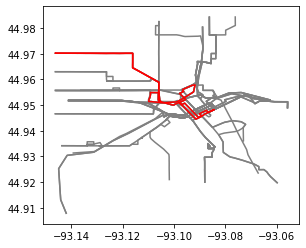

In [26]:
from partridge import geo

selected_trips = transit_net.select_transit_features(simple_transit_selection)

selected_shapes_gdf = TransitNetwork.transit_net_to_gdf(
    transit_net.feed.shapes[
        transit_net.feed.shapes.shape_id.isin(
            transit_net.feed.trips[
                transit_net.feed.trips.trip_id.isin(selected_trips)
            ]['shape_id'].tolist()
        )
    ]
)

all_shapes_gdf =  TransitNetwork.transit_net_to_gdf(transit_net)

all_shapes=all_shapes_gdf.plot(color='gray')

selected_shapes_gdf.plot(ax=all_shapes, color="red")

# 3. Change Feature Attributes

Changes are made by:
1. selecting the features to change
2. defining what properties should change and how

Selections are defined by dictionaries containing selection requirements. 

## Highway Feature Change

 - RoadwayNetwork link features are selected by link features, and conditionally start and end points (A and B nodes).
 - Link features must either have `name` or the unique link key (usually `model_link_id`).  
 - If using `name`, `A` and `B` nodes are required to specify the start and end points of the selection.  
 - If `name` is blank for a portion of the roadway, Network Wrangler will try and 'fill in' the blank spots and make sure that A and B are connected. 
 - Additional refements to the selection can made by specifying additional properties such as `lanes` etc.
 

In [27]:
selected_highway = {
    "link": [{"name": ["I 35E"]}],
    "A": {"osm_node_id": "961117623"},  
    "B": {"osm_node_id": "2564047368"}
}
selected_links   = net.select_roadway_features(selected_highway)
selected_links

[7539, 8104]

### Review selected features

In [32]:
A_id, B_id = net.orig_dest_nodes_foreign_key(selected_highway)
selected_highway_key = (ProjectCard.build_link_selection_query(selected_highway,unique_link_ids=['model_link_id']), A_id, B_id)
map_selection(net.selections[selected_highway_key ], A_id, B_id)

**Evaluate what the base case is for features of interest**

In [33]:
net.links_df.loc[selected_links]['lanes']

7539    3
8104    3
Name: lanes, dtype: int64

### Specify Change

Changes are specified by a dictionary.  For highway changes, there should be a list of dictionaries under `properties` where each entity has a `property` and either `set` for an absolute value or `change`  to direct that a value is changed. 

In [34]:
change = {
    'properties': [
      {
          'property': 'lanes',
          'set': 2,
      }
    ]
}

In [35]:
net.apply_roadway_feature_change(selected_links,change['properties'])
net.links_df.loc[selected_links]['lanes']

7539    2
8104    2
Name: lanes, dtype: int64

#### You can also increment from the existing value using the field `change`
And optionally, you can call out what you think the existing value should be so that it fails if it isn't the case.

In [36]:
change = {
    'properties': [
      {
          'property': 'lanes',
          'existing': 2,
          'change': 1,
      }
    ]
}

net.apply_roadway_feature_change(selected_links,change['properties'])
net.links_df.loc[selected_links]['lanes']

7539    3
8104    3
Name: lanes, dtype: int64

## Transit Feature Change


Transit changes follow the same pattern as highway network changes with a selection and then a change.

In [37]:
transit_selection = {"route_short_name": "3"}
change = {
    'properties': [
      {
          'property': 'headway_secs',
          'set': 600, # ten minute headways
      }
    ]
}
# show existing headways
transit_net.feed.frequencies[
    transit_net.feed.trips.trip_id.isin(
        transit_net.select_transit_features(transit_selection)
    )
]

,trip_id,headway_secs,start_time,end_time
1,14941148-JUN19-MVS-BUS-Weekday-01,830,21600.0,32400.0
2,14941151-JUN19-MVS-BUS-Weekday-01,540,21600.0,32400.0
3,14941153-JUN19-MVS-BUS-Weekday-01,696,32400.0,54000.0
4,14941163-JUN19-MVS-BUS-Weekday-01,830,32400.0,54000.0


In [38]:
transit_net.apply_transit_feature_change(
            transit_net.select_transit_features(transit_selection), change['properties']
        )

# show revised headways
transit_net.feed.frequencies[
    transit_net.feed.trips.trip_id.isin(
        transit_net.select_transit_features(simple_transit_selection)
    )
]

,trip_id,headway_secs,start_time,end_time
1,14941148-JUN19-MVS-BUS-Weekday-01,600,21600.0,32400.0
2,14941151-JUN19-MVS-BUS-Weekday-01,600,21600.0,32400.0
3,14941153-JUN19-MVS-BUS-Weekday-01,600,32400.0,54000.0
4,14941163-JUN19-MVS-BUS-Weekday-01,600,32400.0,54000.0


# 4 - Write out Networks

In [42]:
OUTPATH = "."

In [43]:
net.write(filename="my_net", path=OUTPATH)

In [44]:
transit_net.write(path = OUTPATH)

2020-11-13 16:25:36, INFO: Writing transit to directory: .


# 5 - Project cards to document selections, changes, and metadata

The whole property change process above can be more seamless and replicable by using "project cards" which specify  the selection, changes, and project metadata.   

## Roadway Changes with Project Cards

In [45]:
roadway_project_card_file = os.path.join(
        STPAUL_DIR, "project_cards", '3_multiple_roadway_attribute_change.yml'
    )
    
roadway_project_card = ProjectCard.read(roadway_project_card_file)

net.apply_roadway_feature_change(
    net.select_roadway_features(roadway_project_card.facility),
    roadway_project_card.properties
)


2020-11-13 16:27:04, ERROR: Failed Project Card validation: Validation Error
2020-11-13 16:27:04, ERROR: Project Card File Loc:/Users/elizabeth/Documents/urbanlabs/MetCouncil/working/network_wrangler/notebook/../examples/stpaul/project_cards/3_multiple_roadway_attribute_change.yml
2020-11-13 16:27:04, ERROR: Project Card Schema Loc:/Users/elizabeth/Documents/urbanlabs/MetCouncil/working/network_wrangler/network_wrangler/schemas/project_card.json
2020-11-13 16:27:04, ERROR: [{'name': ['6th', 'Sixth', 'sixth']}] is valid under each of {'required': ['osm_link_id']}, {'required': ['model_link_id']}, {'required': ['name']}
2020-11-13 16:27:04, WARNING: Existing value defined for lanes in project card does not match the value in the roadway network for the selected links


### Transit changes with a project card

In [46]:
transit_project_card_file = os.path.join(
    STPAUL_DIR, "project_cards", '8_simple_transit_attribute_change.yml'
)

transit_project_card = ProjectCard.read(transit_project_card_file)
transit_net.apply_transit_feature_change(
    transit_net.select_transit_features(transit_project_card.facility), 
    transit_project_card.properties
)

# 6 - Scenarios to manage groups of changes

The Scenario object manages groups of projects defined in project cards. 

- Scenarios are initialized by defining a base scenario, which at a minimum specifies the base roadway networks and also may specify a base transit networks and a list of projects that have already been applied.
- Projects can  be "added" or "queued" to a scenario.
- Projects are then "applied" or "built" on the scenario using logic about pre-requisites and co-requisites. 

In [48]:
from network_wrangler import Scenario
my_scenario = Scenario.create_scenario(
    base_scenario={"road_net":net, "transit_net":transit_net}, 
    project_cards_list= [roadway_project_card]
    )

my_scenario.apply_all_projects()

2020-11-13 16:27:20, INFO: Creating Scenario
2020-11-13 16:27:21, INFO: Applying 6th Street Transitway
2020-11-13 16:27:21, INFO: Applying Project to Roadway Network: 6th Street Transitway
2020-11-13 16:27:21, WARNING: Existing value defined for lanes in project card does not match the value in the roadway network for the selected links


In [49]:
my_scenario.applied_projects

['6th Street Transitway']